<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/SPWM_RL_SwitchingFrequency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>PWM with Varying Switching Frequency</h1></b>

Dr. Bingsen Wang

1/26/2025
</center>

#Python Code

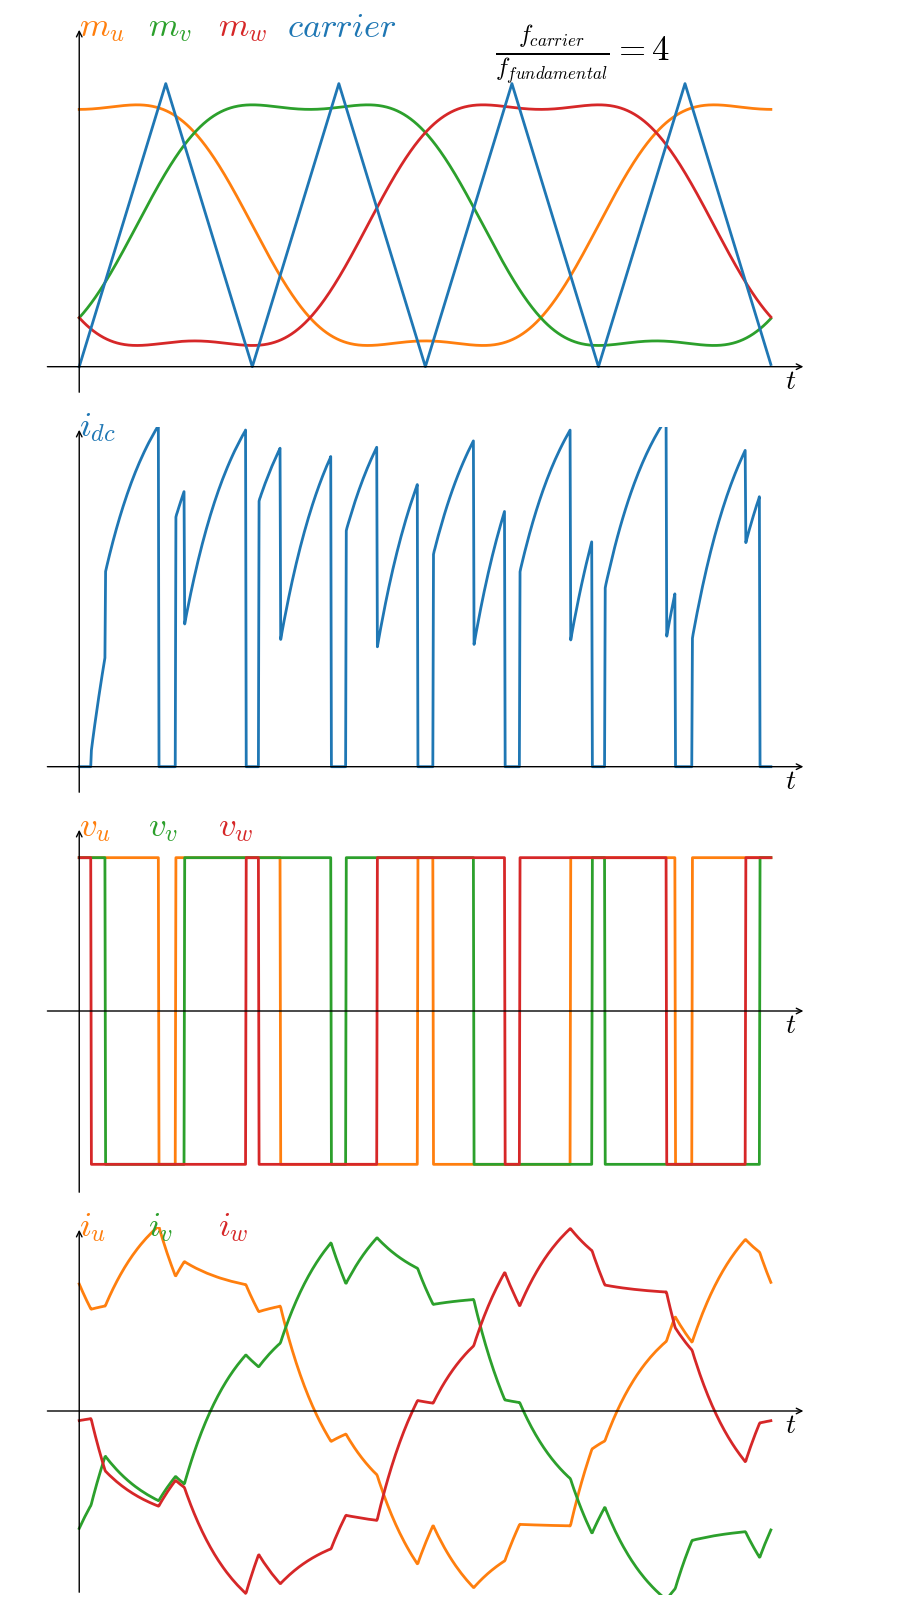

In [54]:
from matplotlib import pyplot,animation,cm
import numpy as np
pyplot.rcParams.update({"font.family":"sans-serif", "mathtext.fontset":"cm"})

#carrier
def carrier(t,f):
  return 1/np.pi*np.arccos(np.cos(2*np.pi*f*t))

#modulation functions
def mf_abc(t,f,MI):
  return [MI/np.sqrt(3)*(np.cos(2*np.pi*f*t-i*2*np.pi/3)-1/6*np.cos(2*np.pi*3*f*t))+.5 for i in range(3)]

#PWM voltage waveforms
def vac_abc(mabc,carr,Vdc):
  return np.array([Vdc*(np.heaviside(mabc[i]-carr,0)-.5) for i in range(3)])

#parameters
f,pf,MI,Vdc = 1,.9,.85,2 #fundamental frequency
r_sw = np.linspace(4,120,59) #ratio of switching frequency over fundamental frequency

clst = list(cm.tab10.colors) #colors of lines
fig = pyplot.figure(figsize=([9,16]))
lines=[]
for k in range(4):
  ax=fig.add_axes([0,.25*k,1,.23],xlim=[-.1,1.2/f],ylim=[(-1.2,-.1)[k//2],1.2])
  ax.axis("off")
  ax.annotate('',(1.05/f,0),(-.05/f,0),arrowprops=dict(arrowstyle="->"))
  ax.annotate('',(0,1.2),(0,(-1.2,-.1)[k//2]),arrowprops=dict(arrowstyle="->"))
  ax.text(1.05/f,0,'$t$  ',va='top',ha='right',size=20)
  cs=[clst[1:4],clst[1:4],[clst[0]],clst[1:4]+[clst[0]]][k]
  txt=[['$i_u$','$i_v$','$i_w$'],['$v_u$','$v_v$','$v_w$'],['$i_{dc}$'],
   ['$m_u$','$m_v$','$m_w$','$carrier$']][k]
  [ax.text(0+i*.1,1.2,txt[i],c=cs[i],size=25,va='center') for i in range(len(cs))]
  lines.append([ax.plot([],[],c=cs[i],lw=2)[0] for i in range(len(cs))])
txt=ax.text(.6/f,1.1,'',size=25,va='center')

def animate(k):
  fsw = r_sw[k]*f
  t = np.arange(0,1/f,1/(256*fsw)) #time series for fft analysis
  Zload = Vdc*MI/np.sqrt(3) #load impedance
  Rload,Xload = Zload*pf,Zload*np.sqrt(1-pf**2) #load resistance and reactance
  carr= carrier(t,fsw) #carrier ranges [0,1]
  mabc = mf_abc(t,f,MI) #modulation functions
  vabc = vac_abc(mabc,carr,Vdc) #pwm waveforms with respect to dc neutral
  vload = vabc-(vabc[0]+vabc[1]+vabc[2])/3 #load voltage w/o common mode
  Vload_fft = np.fft.rfft(vload) #fft of load voltage
  Iload_fft =np.array([[Vload_fft[k,i]/(Rload+1j*i*Xload) for i in range(len(Vload_fft[k]))]
              for k in range(3)])
  iload = np.fft.irfft(Iload_fft) #load current in time domain
  n_min=min(len(iload[0]),len(vabc[0]))
  idc = sum([vabc[i,:n_min]*iload[i,:n_min] for i in range(3)])/Vdc
  [lines[0][i].set_data(t[:n_min],iload[i,:n_min]) for i in range(3)]
  [lines[1][i].set_data(t,vabc[i]) for i in range(3)]
  lines[2][0].set_data(t[:n_min],idc[:n_min])
  [lines[3][i].set_data(t,mabc[i]) for i in range(3)]
  lines[3][3].set_data(t,carr)
  txt.set_text(r'$\frac{f_{carrier}}{f_{fundamental}}='+f'{r_sw[k]:.0f}'+'$')
  return
anim = animation.FuncAnimation(fig, animate, frames=len(r_sw), interval=50)
anim.save("PWM_SwitchingFrequency.mp4",writer=animation.FFMpegWriter(fps=2),dpi=200)